In [8]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import config

print(config.ROOT_FOLDER)

/Users/alexander.prams/autotune


In [9]:
with open(os.path.join(config.ROOT_FOLDER, 'experiment_results/hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    optimizer_results = pickle.load(handle)
    
with open(os.path.join(config.ROOT_FOLDER, 'experiment_results/combined_hpo_dataset_optimizer_results.pickle'), 'rb') as handle:
    combined_optimizer_results = pickle.load(handle)
    
meta_data = optimizer_results['meta']
del optimizer_results['meta']

In [10]:
# Optimizer results dict has structure [optimizer.name][classifier_name][dataset_idx][rep_id] -> optimizer output
optimizers = list(optimizer_results.keys())
classifiers = list(optimizer_results[optimizers[0]].keys())
n_datasets = len(optimizer_results[optimizers[0]][classifiers[0]])
n_reps_per_dataset = len(optimizer_results[optimizers[0]][classifiers[0]][0])
loss_ranges = meta_data['loss_ranges']

print("Optimizers: ", optimizers)
print("Classifiers: ", classifiers)
print("n_datasets: ", n_datasets)
print("n_reps_per_dataset", n_reps_per_dataset)

Optimizers:  ['RandomSearch', 'TPE', 'GA']
Classifiers:  ['libsvm_svc', 'liblinear', 'random_forest']
n_datasets:  10
n_reps_per_dataset 3


In [11]:
def results_to_numpy(optimizer_results, result_idx=1):
    np_results = {}
    for optimizer in optimizer_results:
        print(optimizer)
        tmp_results = {}

        opt_results = optimizer_results[optimizer]
        for classifier in opt_results:
            results = np.array(opt_results[classifier])
            results = np.array(results[:, :, :, result_idx], dtype=np.float32)
            print(results.shape)
            tmp_results[classifier] = -results
        np_results[optimizer] = tmp_results
    return np_results
        
loss_per_time_step = results_to_numpy(optimizer_results)
min_max_normalized_loss_per_time_step = {}
for o in list(loss_per_time_step.keys()):
    min_max_normalized_loss_per_time_step[o] = {}
    for c in list(loss_per_time_step[o].keys()):
        print(loss_per_time_step[o][c].shape)
        tmp_loss = loss_per_time_step[o][c]
        min_loss = loss_ranges[c][:, 0][:, None, None]
        max_loss = loss_ranges[c][:, 1][:, None, None]
        min_max_normalized_loss_per_time_step[o][c] = (tmp_loss - min_loss) / (max_loss - min_loss)

RandomSearch
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
TPE
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
GA
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)
(10, 3, 10)


libsvm_svc
(10, 3, 10)
libsvm_svc
(10, 3, 10)
libsvm_svc
(10, 3, 10)


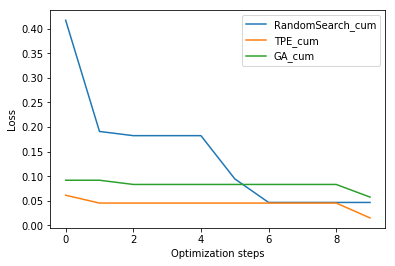

liblinear
(10, 3, 10)
liblinear
(10, 3, 10)
liblinear
(10, 3, 10)


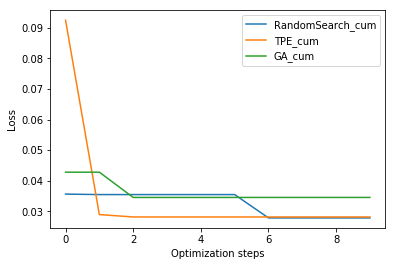

random_forest
(10, 3, 10)
random_forest
(10, 3, 10)
random_forest
(10, 3, 10)


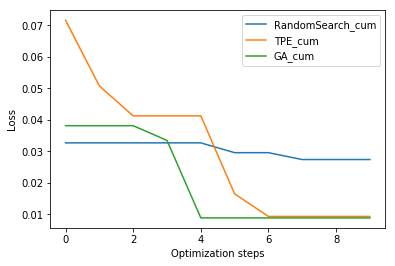

In [12]:
# Plot raw losses

def plot_results(np_results, dataset_idx=0, avg_datasets=False):
    for classifier in np_results[list(np_results.keys())[0]]:
        for optimizer in np_results:
            print(classifier)
            print(np_results[optimizer][classifier].shape)
            if avg_datasets:
                value_per_timestep = np.nanmean(np_results[optimizer][classifier], axis=(0, 1))
            else:
                value_per_timestep = np.nanmean(np_results[optimizer][classifier][dataset_idx], axis=(0))
            
            cumulative_min_data = [min(value_per_timestep[0:i+1]) for i in range(len(value_per_timestep))]
            #print(value_per_timestep.shape)
            plt.plot(cumulative_min_data, label=optimizer + "_cum")
            #plt.plot(value_per_timestep, label=optimizer)
        plt.xlabel("Optimization steps")
        plt.ylabel("Loss")
        plt.legend(loc='upper right')
        plt.show()

plot_results(loss_per_time_step)

libsvm_svc
(10, 3, 10)
libsvm_svc
(10, 3, 10)
libsvm_svc
(10, 3, 10)


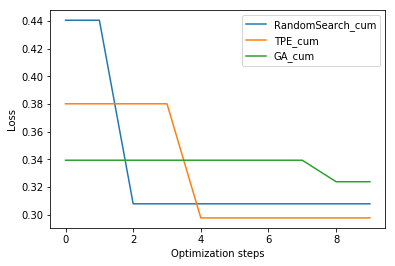

liblinear
(10, 3, 10)
liblinear
(10, 3, 10)
liblinear
(10, 3, 10)


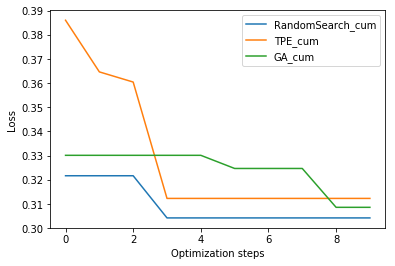

random_forest
(10, 3, 10)
random_forest
(10, 3, 10)
random_forest
(10, 3, 10)


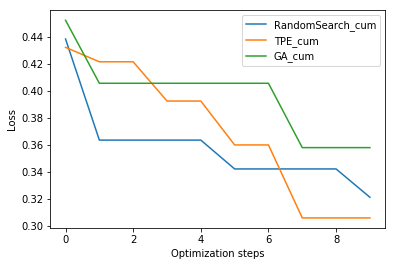

In [13]:
# Plot min max normalized losses

plot_results(min_max_normalized_loss_per_time_step, avg_datasets=True)

In [15]:
### Combined results
def combined_results_to_numpy(combined_optimizer_results, result_idx=1):
    np_results = {}
    for optimizer in combined_optimizer_results:
        print(optimizer)
        opt_results = combined_optimizer_results[optimizer]
        results = np.array(opt_results)
        results = np.array(results[:, :, :, result_idx], dtype=np.float32)
        print(results.shape)
        np_results[optimizer] = -results
    return np_results
        
combined_loss_per_time_step = combined_results_to_numpy(combined_optimizer_results)
combined_min_max_normalized_loss_per_time_step = {}
for o in list(combined_loss_per_time_step.keys()):
    tmp_loss = combined_loss_per_time_step[o]
    min_loss = loss_ranges[c][:, 0][:, None, None]
    max_loss = loss_ranges[c][:, 1][:, None, None]
    combined_min_max_normalized_loss_per_time_step[o] = (tmp_loss - min_loss) / (max_loss - min_loss)

RandomSearch
(10, 3, 10)
TPE
(10, 3, 10)
GA
(10, 3, 10)


In [ ]:
def plot_combined_results(np_results, dataset_idx=0, avg_datasets=False):
    for optimizer in np_results:
        print(np_results[optimizer].shape)
        if avg_datasets:
            value_per_timestep = np.nanmean(np_results[optimizer], axis=(0, 1))
        else:
            value_per_timestep = np.nanmean(np_results[optimizer][dataset_idx], axis=(0))
        
        cumulative_min_data = [min(value_per_timestep[0:i+1]) for i in range(len(value_per_timestep))]
        #print(value_per_timestep.shape)
        plt.plot(cumulative_min_data, label=optimizer + "_cum")
        #plt.plot(value_per_timestep, label=optimizer)
    plt.xlabel("Optimization steps")
    plt.ylabel("Loss")
    plt.legend(loc='upper right')
    plt.show()

plot_combined_results(combined_min_max_normalized_loss_per_time_step, avg_datasets=True)

[[0.02490085 0.21575822 0.21152571 2.09966121 0.20737231 4.261467
  0.33610907 0.97108177 4.261467   0.97108177]
 [0.97100442 4.261467   0.38593036 0.40248527 0.11204229 0.17418687
  0.58094023 4.261467   0.04978127 0.21152571]
 [0.03736016 0.96686969 0.78010706 0.02074656 4.261467   0.3609895
  0.97108177 0.96692836 0.76353257 0.02493996]]


IndexError: arrays used as indices must be of integer (or boolean) type